## ASF Setup

In [11]:
import sys, platform
print(sys.version)


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [12]:
# Core deps
%pip -q install "numpy>=1.23" "scipy>=1.10" "matplotlib>=3.5"

# PySCF (binary wheels available for Colab)
%pip -q install "pyscf>=2.3,<2.7"

# Active Space Finder from GitHub (recommended on Colab)
%pip -q install git+https://github.com/HQSquantumsimulations/ActiveSpaceFinder.git



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [13]:
import sys, pathlib, pyscf

dmrg_dir = pathlib.Path(pyscf.__file__).parent / "dmrgscf"
dmrg_dir.mkdir(parents=True, exist_ok=True)
stub = dmrg_dir / "settings.py"

stub.write_text("""# Auto-generated stub for PySCF DMRG on Colab (CASCI-only use)
# Point to a harmless executable so imports succeed; we won't actually run DMRG.
BLOCKEXE = '/bin/false'           # external DMRG executable (stub)
BLOCKSCRATCHDIR = '/tmp'          # scratch directory
BLOCK_VERSION = '1.5'             # arbitrary tag
CHEMPS2EXE = '/bin/false'         # optional other DMRG backend (stub)
""")

print("Wrote:", stub)


Wrote: /usr/local/lib/python3.12/dist-packages/pyscf/dmrgscf/settings.py


# Binary knapsack optimization on a qumode

## Prerequisite

Cell for Google Colab users.

Packages.

In [14]:
!pip install qutip

In [15]:
import numpy as np
import qutip as qt
import sympy as sp
import scipy.optimize as sciopt

from functools import partial

In [16]:
import matplotlib.pyplot as plt

## Ansatz

### Basics

In [17]:
def get_cvec_np(r, theta):
    r = np.array(r)
    theta = np.array(theta)
    return r * np.exp(1j * theta)

In [18]:
def pack_variables(beta_mag, beta_arg, theta, phi):
    Xvec = np.concatenate([
        beta_mag.ravel(),
        beta_arg.ravel(),
        theta.ravel(),
        phi.ravel()
    ])
    return Xvec


def unpack_variables(Xvec, ndepth):
    size = ndepth * 2

    beta_mag = Xvec[:size].reshape((ndepth, 2))
    beta_arg = Xvec[size:2*size].reshape((ndepth, 2))
    theta = Xvec[2*size:3*size].reshape((ndepth, 2))
    phi = Xvec[3*size:].reshape((ndepth, 2))

    return beta_mag, beta_arg, theta, phi

In [19]:
def qproj00():
    return qt.basis(2, 0).proj()


def qproj11():
    return qt.basis(2, 1).proj()


def qproj01():
    op = np.array([[0, 1], [0, 0]])
    return qt.Qobj(op)


def qproj10():
    op = np.array([[0, 0], [1, 0]])
    return qt.Qobj(op)

### ECDs with qubit rotations

Qubit rotation with qumode echoed conditional displacement (ECD) operators ([reference](https://doi.org/10.1038/s41567-022-01776-9)) for one qubit and two qumodes

\begin{align*}
U (\vec{\beta}, \vec{\theta}, \vec{\phi})
&= ECD_2 (\beta_2) \:
\big[ R (\theta_2, \phi_2) \otimes I \otimes I \big] \:
ECD_1 (\beta_1) \:
\big[ R (\theta_1, \phi_1) \otimes I \otimes I \big]
\\
ECD_1 (\beta_1)
&= |1 \rangle \langle 0| \otimes D (\beta_1 / 2) \otimes I  
+ |0 \rangle \langle 1| \otimes D (-\beta_1 / 2) \otimes I,
\\
ECD_2 (\beta_2)
&= |1 \rangle \langle 0| \otimes I \otimes D (\beta_2 / 2)
+ |0 \rangle \langle 1| \otimes I \otimes D (-\beta_2 / 2),
\end{align*}

where
$ R (\theta, \phi)
= e^{ - i (\theta / 2) \big[ \cos(\phi) X + \sin(\phi) Y \big] } $ and
$ D (\beta) = e^{ \beta a^\dagger - \beta^* a } $.

In [20]:
def qubit_rot(theta, phi):
    """
    R (theta, phi) = exp[ −i (theta/2) ( X cos(phi) + Y sin(phi) ) ].

    Arguments:
    theta, phi: rotation parameters
    """
    gen = ( qt.sigmax() * np.cos(phi) )
    gen += ( qt.sigmay() * np.sin(phi) )

    H = -1j * (theta / 2) * gen

    return H.expm()

In [21]:
def ecd_op(beta, theta, phi, cind, nfocks):
    """
    ECD operator.

    Arguments:
    beta -- ECD parameter
    theta, phi -- rotation parameters
    cind -- qumode index
    nfocks -- Fock cutoffs
    """
    # Validate cind
    if cind not in (0, 1):
        raise ValueError("cind must be 0 or 1")

    # ECD
    if cind == 0:
        E2 = qt.tensor(qproj10(), qt.displace(nfocks[0], beta / 2))
        E2 += qt.tensor(qproj01(), qt.displace(nfocks[0], -beta / 2))
        E2 = qt.tensor(E2, qt.qeye(nfocks[1]))
    else:
        E2 = qt.tensor(qproj10(), qt.qeye(nfocks[0]), qt.displace(nfocks[1], beta / 2))
        E2 += qt.tensor(qproj01(), qt.qeye(nfocks[0]), qt.displace(nfocks[1], -beta / 2))

    return E2

In [22]:
def ecd_rot_op(beta, theta, phi, nfocks):
    """
    ECD-rotation operator.

    Arguments:
    beta -- ECD parameters
    theta, phi -- rotation parameters
    nfocks -- Fock cutoffs
    """
    # Rotations
    R1 = qt.tensor(qubit_rot(theta[0], phi[0]), qt.qeye(nfocks[0]), qt.qeye(nfocks[1]))
    R2 = qt.tensor(qubit_rot(theta[1], phi[1]), qt.qeye(nfocks[0]), qt.qeye(nfocks[1]))

    # ECDs
    E1 = ecd_op(beta[0], theta[0], phi[0], 0, nfocks)
    E2 = ecd_op(beta[1], theta[1], phi[1], 1, nfocks)

    return E2 * R2 * E1 * R1

Build the ansatz matrix of depth $N_d$

$$ \mathcal{U} (\bar{\beta}, \bar{\theta}, \bar{\phi})
= U (\vec{\beta}_{N_d}, \vec{\theta}_{N_d}, \vec{\phi}_{N_d}) \cdots
U (\vec{\beta}_1, \vec{\theta}_1, \vec{\phi}_1),
$$

where $\bar{\beta}, \bar{\theta}$, and $\bar{\phi}$ are matrices of dimensions $N_d \times 2$.
The matrix $\bar{\beta}$ is also complex-valued.

In [23]:
def ecd_rot_ansatz(bmag_mat, barg_mat, theta_mat, phi_mat, nfocks):
    """
    ECD-rotation ansatz.

    Arguments:
    bmag_mat, barg_mat -- ECD parameters
    theta_mat, phi_mat -- rotation parameters
    nfocks -- Fock cutoffs
    """
    # Check
    if bmag_mat.shape != barg_mat.shape:
        raise ValueError("Dimensions of bmag_mat and barg_mat do not match.")
    beta_mat = get_cvec_np(bmag_mat, barg_mat)
    if beta_mat.shape != theta_mat.shape:
        raise ValueError("Lengths of beta_mat and theta_mat do not match.")
    if beta_mat.shape != phi_mat.shape:
        raise ValueError("Lengths of beta_mat and phi_mat do not match.")

    # Initialize
    ndepth = beta_mat.shape[0]
    uni = ecd_rot_op(beta_mat[0, :], theta_mat[0, :], phi_mat[0, :], nfocks)

    # Check
    if ndepth == 1:
        return uni

    # Loop through blocks
    for i in range(1, ndepth):
        new_uni = ecd_rot_op(beta_mat[i, :], theta_mat[i, :], phi_mat[i, :], nfocks)
        uni = ( new_uni * uni )

    return uni

## Hamiltonian

### Basics

In [24]:
def decimal_to_binary(decimal_number, length):
    # Convert the decimal number to binary and strip the '0b' prefix
    binary_representation = bin(decimal_number)[2:]

    # Pad the binary representation with leading zeros if necessary
    padded_binary = binary_representation.zfill(length)

    # If the padded length is less than the specified length, raise an error
    if len(padded_binary) > length:
        raise ValueError("The binary representation is longer than the specified length.")

    return padded_binary


def binary_to_decimal(binary_string, length):
    # Validate that the input is a binary string of the specified length
    if len(binary_string) != length:
        raise ValueError(f"Input must be a binary string of length {length}.")

    if not all(bit in '01' for bit in binary_string):
        raise ValueError("Input must be a binary string.")

    # Convert the binary string to decimal
    decimal_number = int(binary_string, 2)

    return decimal_number

In [25]:
def find_basis_state(state_vector):
    # Convert input to a Qobj if it isn't already
    if not isinstance(state_vector, qt.Qobj):
        state_vector = qt.Qobj(state_vector)

    # Get the number of qubits based on the length of the state vector
    N = int(np.log2(state_vector.shape[0]))

    # Check if the state vector is normalized
    if not np.isclose(state_vector.norm(), 1):
        raise ValueError("Input state vector must be normalized.")

    # Generate all possible basis states for N qubits
    basis_states = [qt.basis(2**N, i) for i in range(2**N)]

    # Check overlap with all basis states
    for index, b in enumerate(basis_states):
        overlap = state_vector.overlap(b)
        if np.isclose(overlap, 1):
            # Convert index to binary representation
            return format(index, f'0{N}b')  # Format as binary string with leading zeros

    # If no overlap found, return None (or raise an error)
    return None

### Qubit

In [26]:
def binary_to_qubit_ham(H_bin, symbol_list, include_id=False):
    """
    Map a symbolic binary Hamiltonian to a spin Hamiltonian.

    Arguments:
    H_bin -- The binary Hamiltonian as a SymPy object
    symbol_list -- SymPy symbols defining the Hamiltonian
    include_id -- identity as symbol (True) or value 1 (False)
    """
    # Initialize spin variables (Z0, Z1, ..., Zn)
    z_symbols = sp.symbols('z:{}'.format(len(symbol_list)))

    # Define the identity operator (I_j)
    Ident = sp.symbols(r'\mathbb{I}') if include_id else 1.0

    # Create a mapping dictionary from binary symbols to spin expressions
    bin2spin_dict = {
        symbol: (1/2)*(Ident - z) for symbol, z in zip(symbol_list, z_symbols)
    }

    # Convert the binary Hamiltonian to a spin Hamiltonian
    spin_ham = H_bin.subs(bin2spin_dict).expand()

    # Z^2 = I
    sq_z = [z**2 for z in z_symbols]
    sq_values = [Ident] * len(z_symbols)  # All squared terms map to the identity
    spin_squared_map = dict(zip(sq_z, sq_values))

    # Substitute squared terms
    red_spin_ham = spin_ham.subs(spin_squared_map)

    return red_spin_ham


def check_spinz(input_list, spinz):
    out_val = ['I']*len(spinz)
    for ll in range(len(input_list)):
        out_val[int(input_list[ll].strip('z'))] = 'Z'
    return out_val


def sympy_to_pauli_dict(smpy_exp):
    """
    Convert a sympy spin Hamiltonian expression to a dictionary with
    Pauli words as keys and string coefficients as values.
    """
    # Determine the number of qubits
    spinz = smpy_exp.free_symbols

    # Split at spaces so we have the individual terms/coefficients
    split_expr = str(smpy_exp).split()

    # Firs iteration
    matrix_dict = {}
    split_term = split_expr[0].split('*')
    tmp_coeff = split_term[0]
    tmp_paulis = split_term[1:]
    pauli_word = ''.join(check_spinz(tmp_paulis, spinz))
    matrix_dict[pauli_word] = tmp_coeff

    # Iterate through the remaining terms
    for ii in range(1, len(split_expr), 2):
        tmp_sign = split_expr[ii]
        split_term = split_expr[ii+1].split('*')
        tmp_coeff  = split_term[0]
        tmp_paulis = split_term[1:]
        pauli_word = ''.join(check_spinz(tmp_paulis, spinz))
        matrix_dict[pauli_word] = tmp_sign+tmp_coeff

    return matrix_dict


def binary_to_pauli_list(H_total, symbol_list):
    """
    Maps a binary Hamiltonian to Pauli terms and coefficients.

    Arguments:
    H_total -- The binary Hamiltonian
    symbol_list -- symbols defining the Hamiltonian
    """
    spin_ham = binary_to_qubit_ham(H_total, symbol_list)
    op_dict = sympy_to_pauli_dict(spin_ham)

    return [[key, float(value)] for key, value in op_dict.items()]

### Qudit

In [27]:
def matrices_to_qudit_list(matrices):
    """
    Maps list of matrices to qudit terms.

    Argument:
    matrices -- list of matrices
    """
    # Initialize the result list
    result = []

    # Get the number of matrices
    num_matrices = len(matrices)

    # Create a list to store diagonal values from each matrix
    diagonal_values = []

    # Collect diagonal values and their labels
    for index, matrix in enumerate(matrices):
        diag = np.diagonal(matrix)  # Get the diagonal elements
        diagonal_values.append((diag, index))  # Store as (diagonal_elements, index)

    # Recursive function to generate combinations of indices
    def generate_combinations(combination, depth):
        if depth == num_matrices:
            # Calculate the product for the current combination
            product = 1
            label = []
            for matrix_index, diag_index in combination:
                product *= matrices[matrix_index][diag_index, diag_index]
                label.append(f'P{diag_index}')
            result.append([ ', '.join(label), product ])
            return

        # Loop through the diagonal elements of the current matrix
        diag, matrix_index = diagonal_values[depth]
        for i in range(len(diag)):
            generate_combinations(combination + [(matrix_index, i)], depth + 1)

    # Start generating combinations
    generate_combinations([], 0)

    return result


def partition_string_list(input_list, partition_vector):
    """
    Partition the string in the input list based on the partition vector.

    Arguments:
    input_list -- A list where the first element is a string to partition,
                  and the last element is a value to retain.
    partition_vector -- A list of integers that specifies the lengths of the partitions.

    Returns:
    A new list with the partitioned string and the retained value.
    """
    # Ensure the partition_vector is valid
    string_part = input_list[0]
    total_length = sum(partition_vector)

    if total_length != len(string_part):
        raise ValueError("The sum of the partition vector must equal the length of the string.")

    # Partition the string based on the partition vector
    partitions = []
    start_index = 0

    for size in partition_vector:
        partitions.append(string_part[start_index:start_index + size])
        start_index += size

    # Return the modified list
    return partitions + [input_list[-1]]


def partitioned_pauli_term_to_qudit_term(pterm):
    mat_list = []
    for i in range(len(pterm) - 1):
        new_mat = generate_tensor_product(pterm[i])
        if i == 0:
            new_mat *= pterm[-1]
        mat_list.append(np.real( new_mat.full() ))

    return matrices_to_qudit_list(mat_list)


def pauli_list_to_qudit_terms(pterms, partition_vector):
    term_list = []
    for term in pterms:
        new_term = partition_string_list(term, partition_vector)
        qudit_term = partitioned_pauli_term_to_qudit_term(new_term)
        term_list.append(qudit_term)

    result_dict = {}
    for lst in term_list:
        for key, value in lst:
            if key in result_dict:
                result_dict[key] += value
            else:
                result_dict[key] = value
    return [[key, value] for key, value in result_dict.items()]

### Knapsack

In [28]:
def binary_knapsack_ham(l_val, values, weights, max_weight, include_id=False):
    """
    Generates the binary Hamiltonian for the knapsack problem.

    Arguments:
    l_val -- lambda penalty parameter
    values -- item values
    weights -- item weights
    max_weight -- total weight capacity
    include_id -- identity as symbol (True) or value 1 (False)

    Returns:
    H_total -- The binary Hamiltonian
    """
    # Number of primary variables
    N_qb = len(weights)

    # Symbols
    symbol_list = list(sp.symbols('x_:{}'.format(str(N_qb))))
    Ident = sp.symbols(r'\mathbb{I}') if include_id else 1.

    # E = sum(i) v(i) x(i)
    H_prob = sum(values[ii] * symbol_list[ii] for ii in range(N_qb))

    # Calculate scaling factor
    max_weight_bin_str = bin(max_weight).lstrip('0b')  # Step 1
    max_val = 2**len(max_weight_bin_str) - 1  # Step 2
    scaling_factor = max_val / max_weight  # Step 3

    # Apply scaling to weights
    scaled_weights = [weight * scaling_factor for weight in weights]

    # W0 = sum(i) w(i) x(i)
    H_constraints = sum(scaled_weights[ii] * symbol_list[ii] for ii in range(N_qb))

    # Bitstring representation converted to list
    bin_weight = list(bin(max_weight).lstrip('0b'))[::-1]

    # Auxiliary symbol indices start after the primary variables
    aux_symbols = sp.symbols('x_{}:{}'.format(str(N_qb), str(N_qb + len(bin_weight))))

    # A = sum(i) 2^i y(i)
    H_constraints_aux = sum(aux_symbols[ii] * 2**ii for ii in range(len(bin_weight)))

    # Full Hamiltonian
    H_total = -H_prob + l_val * (max_weight - H_constraints - H_constraints_aux)**2

    # Construct full list of symbols in expression
    symbol_list.extend(list(aux_symbols))

    # Create a list of x_j**2
    sq_syms = [temp_sym**2 for temp_sym in symbol_list]

    # Maps x_j^{2} to x_j:
    conv_dict = dict(zip(sq_syms, list(symbol_list)))

    # Final binary Hamiltonian
    H_total = H_total.subs(conv_dict)

    return H_total, symbol_list

In [29]:
def generate_tensor_product(string):
    """
    Get QuTip object given a string representing a Pauli word.
    """
    # Define a mapping of characters to corresponding QuTiP operators
    operator_map = {
        'I': qt.qeye(2),  # Identity operator
        'X': qt.sigmax(),  # Pauli-X operator
        'Y': qt.sigmay(),  # Pauli-Y operator
        'Z': qt.sigmaz()   # Pauli-Z operator
    }

    # Create a list to collect the operators
    operators = []

    # Append the corresponding operators based on the input string
    for char in string:
        operators.append(operator_map[char])

    # Compute the tensor product of all operators in the list
    U = qt.tensor(*operators).full()

    return qt.Qobj(U)


def qubit_op_to_ham(pterms):
    """
    Get QuTip object given a set of Pauli words and correspdoing coefficients.
    """
    terms = []
    for p in pterms:
        term = ( p[1] * generate_tensor_product(p[0]) )
        terms.append(term)

    return sum(terms)

## Loss function

We want to minimize the following cost function:

$$ \min_{ \overrightarrow{\beta}, \overrightarrow{\theta}, \overrightarrow{\phi} } E
= \langle \psi (\overrightarrow{\beta}, \overrightarrow{\theta}, \overrightarrow{\phi}) | \:
H \: |\psi (\overrightarrow{\beta}, \overrightarrow{\theta}, \overrightarrow{\phi})\rangle,
$$
where $H$ is the two-qumode Hamiltonian and $|\psi \rangle$ is the two-qumode state traced from the ECD-rotation ansatz $|\Psi \rangle$.

In [30]:
def state_from_ecd(Xvec, ndepth, nfocks):
    """
    Qumode state |Psi> = U ( |0> |0, 0> ).

    Arguments:
    Xvec -- ECD-rotation parameters
    ndepth -- circuit depth
    nfocks -- Fock cutoffs
    """
    # Parameters
    beta_mag, beta_arg, theta, phi = unpack_variables(Xvec, ndepth)

    # ECD unitary
    U = ecd_rot_ansatz(beta_mag, beta_arg, theta, phi, nfocks)

    # U |0, 0, 0>
    vac = qt.tensor( qt.basis(2, 0), qt.basis(nfocks[0], 0), qt.basis(nfocks[1], 0) )
    psi = U * vac

    return psi

In [31]:
def energy_val(Xvec, ndepth, nfocks, H):
    """
    Compute <psi | H |psi > where

    |psi (n, m)> <== U ( |0> |0, 0> ).

    Arguments:
    Xvec -- ansatz ECD-rotation parameters
    H -- QuTip two-qumode Hamiltonian
    nfock -- Fock cutoff for qumode
    ndepth -- circuit depth
    """
    # Qubit-qubit-qumode state
    psi = state_from_ecd(Xvec, ndepth, nfocks)
    psi = qt.Qobj( psi.full() )

    # Expectation value
    ham = qt.Qobj( H.full() )
    en = qt.expect(ham, psi)

    return en

## Analysis

In [32]:
def generate_triples(nfocks):
    # Create ranges for q, n, and m
    q_range = np.arange(2)
    n_range = np.arange(nfocks[0])
    m_range = np.arange(nfocks[1])

    # Create a meshgrid of q, n, and m with valid indexing
    q_grid, n_grid, m_grid = np.meshgrid(q_range, n_range, m_range, indexing='ij')

    # Stack the grids to get (q, n, m) triples
    triples = np.stack((q_grid.ravel(), n_grid.ravel(), m_grid.ravel()), axis=-1)

    return triples

In [33]:
def num_prob_basis(Xvec, nvec, ndepth, nfocks):
    """
    | <psi | q, n, m> |^2, where

    |psi> <== U |0, 0, 0>.

    Arguments:
    Xvec -- ansatz parameters
    nvec -- Fock basis state indices
    nfocks -- Fock cutoffs
    ndepth -- circuit depth
    """
    # Qubit-qubit-qumode state
    psi = state_from_ecd(Xvec, ndepth, nfocks)

    # |q, n, m >
    state = qt.tensor(qt.basis(2, nvec[0]),
                      qt.basis(nfocks[0], nvec[1]),
                      qt.basis(nfocks[1], nvec[2]) )

    # Expectation value
    P0 = psi.overlap(state)

    return np.abs(P0)**2


def num_prob_all(Xvec, ndepth, nfocks):
    """
    | <psi | q, n, m> |^2 for all (n, m).

    Arguments:
    Xvec -- ansatz parameters
    nfock -- Fock cutoff for single qumode
    nvec -- Fock basis state indices
    """
    # Initialize
    N1 = generate_triples(nfocks)
    ntriples = N1.shape[0]

    # Generate
    P1 = []
    for i in range(ntriples):
        P1.append( num_prob_basis(Xvec, N1[i, :], ndepth, nfocks) )

    return np.array(P1)

## Optimization

In [34]:
def ecd_opt_vqe(H, ndepth, nfocks, maxiter=100, method='COBYLA', verb=0,
                threshold=1e-08, print_freq=10, Xvec=[]):
    """
    Minimize the cost function using SciPy-based methods.

    Arguments:
    H -- QuTip Hamiltonian
    ndepth -- ansatz circuit depth
    nfocks -- Fock cutoffs
    maxiter -- maximum number of iterations
    method -- optimization method
    threshold -- error tolerance
    Xvec -- optional initial guesses
    print_freq -- frequency of printing and storing intermediate results
    """
    # Bound parameters
    beta_mag_min = 0.0
    beta_mag_max = 10.0
    beta_arg_min = 0.0
    beta_arg_max = 2 * np.pi
    theta_min = 0.0
    theta_max = np.pi
    phi_min = 0.0
    phi_max = 2 * np.pi

    # Define bounds
    size = ndepth * 2
    beta_mag_bounds = [(beta_mag_min, beta_mag_max)] * size
    beta_arg_bounds = [(beta_arg_min, beta_arg_max)] * size
    theta_bounds = [(theta_min, theta_max)] * size
    phi_bounds = [(phi_min, phi_max)] * size
    bounds = beta_mag_bounds + beta_arg_bounds + theta_bounds + phi_bounds

    # Guess
    if len(Xvec) == 0:
        beta_mag = np.random.uniform(0, 3, size=(ndepth, 2))
        beta_arg = np.random.uniform(0, np.pi, size=(ndepth, 2))
        theta = np.random.uniform(0, np.pi, size=(ndepth, 2))
        phi = np.random.uniform(0, np.pi, size=(ndepth, 2))
        Xvec = pack_variables(beta_mag, beta_arg, theta, phi)

    # Loss function
    obj_fun = partial(energy_val, ndepth=ndepth, nfocks=nfocks, H=H)

    # Intermediate values
    iteration_step = 0
    intermediate_results = []

    def callback(xk):
        nonlocal iteration_step
        iteration_step += 1
        loss_value = obj_fun(xk)
        if verb == 1 and (iteration_step % print_freq == 0):
            print("-------------------")
            print(f"iter: {iteration_step}")
            print(f"fval: {loss_value}")

        # Store intermediate results
        if iteration_step % print_freq == 0:
            intermediate_results.append((loss_value, xk.copy()))

    # SciPy options
    options = {'disp': True, 'maxiter': maxiter}

    # Optimize
    result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds,
                             tol=threshold, options=options, callback=callback)

    return result.fun, result.x, intermediate_results

## ASF Helper

In [39]:
from typing import Dict, Tuple

def get_entanglement_from_asf_water(
    *,
    basis: str = "sto-3g",
    active_orbitals: int = 4,
    switch_dmrg: int = 50,   # keep CASCI for small systems; lower to trigger DMRG if desired
    root: int = 0,
) -> Tuple[
    Dict[int, float],                 # s_dict (ASF-selected active space; global MO indices)
    Dict[Tuple[int, int], float],     # I_dict (ASF-selected active space; global MO indices)
    Dict[int, float],                 # s_full_dict (ALL orbitals; global MO indices)
    Dict[Tuple[int, int], float],     # I_full_dict (ALL unordered MO pairs; zeros included)
]:
    """Compute ASF-derived entropies and pair information for H2O.

    Two views are returned:
      (1) Active-space view (ASF-selected K orbitals): s_dict, I_dict
      (2) Full-space view (ALL MOs correlated):       s_full_dict, I_full_dict

    The full-space view does **not** run any selection. It runs CASCI/DMRG on all
    MOs in the MP2-NO basis that ASF prepared.
    """

    try:  # environment / optional deps
        from pyscf import gto
        from asf.wrapper import sized_space_from_mol, create_asf_switched_cisolver
        from asf.asfbase import ActiveSpace
        from asf.utility import pictures_Jmol, show_mos_grid
        from pathlib import Path
        import shutil
        import glob
        import os
        import traceback
        import subprocess
    except Exception as exc:
        raise RuntimeError(
            "Active Space Finder is required for this workflow. Install it via\n"
            "  pip install active-space-finder pyscf\n"
            "and ensure the optional block2 backend is available for DMRG."
        ) from exc

    if active_orbitals <= 0:
        raise ValueError("'active_orbitals' must be positive")

    # --- Build molecule (standard water geometry) ---
    mol = gto.M(
        atom="""
    O 0.000000 0.000000 0.000000
    H 0.000000 -0.757000 0.587000
    H 0.000000  0.757000 0.587000
    """,
        basis=basis,
        charge=0,
        spin=0,
        symmetry=True,                # <-- add symmetry
        symmetry_subgroup='C2v',      # <-- optional, makes the labels explicit
        verbose=0,
    ).build()

    # -------------------------------------------------------------------------
    # (1) ASF-selected active space (benchmark view): K = active_orbitals
    # SCF -> MP2 natural orbitals -> small CASCI/DMRG to analyze -> pick K.
    space_sel = sized_space_from_mol(
        mol,
        size=active_orbitals,
        verbose=True,
        switch_dmrg=switch_dmrg,
    )


    calc_sel = create_asf_switched_cisolver(
        mol=mol,
        initial_space=space_sel,
        spin=mol.spin,
        nroots=max(1, root + 1),
        switch_dmrg=switch_dmrg,
    )
    calc_sel.calculate()

    # Entropies are returned in ACTIVE order; map them to global MO indices.
    orbdens_sel = calc_sel.one_orbital_density(root=root)
    s_active = np.asarray(calc_sel.one_orbital_entropy(orbdens_sel, root=root), float)
    active_indices = [int(i) for i in space_sel.mo_list]
    s_dict: Dict[int, float] = {mo: float(s_active[k]) for k, mo in enumerate(active_indices)}








    nmo = int(space_sel.mo_coeff.shape[1])
    all_indices = list(range(nmo))


    # Pair info: absolute diagonal cumulant; pick only pairs inside the selected active space.
    # diagonal_cumulant(..., full_space=True) expands onto the full MO index grid.
    cum_full_sel = np.asarray(calc_sel.diagonal_cumulant(root=root, full_space=True), float)
    I_dict: Dict[Tuple[int, int], float] = {}
    for i, a in enumerate(active_indices):
        for b in active_indices[i + 1 :]:
            w = float(abs(cum_full_sel[a, b]))
            if np.isfinite(w) and w != 0.0:
                I_dict[(a, b)] = w

    # -------------------------------------------------------------------------
    # (2) Full-space view (ALL orbitals active; NO selection)
    # -------------------------------------------------------------------------
    # Use the MP2-NO coefficient matrix that ASF already built (contains *all* MOs).
    nmo = int(space_sel.mo_coeff.shape[1])

    # Construct a full-space ActiveSpace: all orbitals active, all electrons active.
    # This simply requests a CASCI/DMRG calculation on the entire MO set.
    full_space = ActiveSpace(
        nel=mol.nelectron,
        mo_list=list(range(nmo)),
        mo_coeff=space_sel.mo_coeff,
    )

    calc_full = create_asf_switched_cisolver(
        mol=mol,
        initial_space=full_space,
        spin=mol.spin,
        nroots=max(1, root + 1),
        switch_dmrg=switch_dmrg,
    )
    calc_full.calculate()

    # Full-space single-orbital entropies and diagonal cumulant
    orbdens_full = calc_full.one_orbital_density(root=root)                 # N x 4 for all MOs
    s_full = np.asarray(calc_full.one_orbital_entropy(orbdens_full, root=root), float)  # length N
    s_full_dict: Dict[int, float] = {i: float(s_full[i]) for i in range(nmo)}

    cum_full = np.asarray(calc_full.diagonal_cumulant(root=root, full_space=True), float)
    I_full_dict: Dict[Tuple[int, int], float] = {}
    for i in range(nmo):
        for j in range(i + 1, nmo):
            w = float(abs(cum_full[i, j]))
            # Include zeros; sanitize non-finite values to 0.0 for completeness.
            if not np.isfinite(w):
                w = 0.0
            I_full_dict[(i, j)] = w

    return s_dict, I_dict, s_full_dict, I_full_dict




## Explore

Here, we explore the mapping of an active space problem to a BKP problem as described in Section IV.B of the manuscript

In [36]:
def asf_qubo_ham(alpha, beta, s, I, K, lam):
    # s: 1D array of s_i; I: 2D upper-tri matrix of I_ij (i<j)
    n = len(s)
    x = sp.symbols(f'x_0:{n}')
    # coefficients with penalty folded in
    a = [-alpha*s[i] + lam*(1-2*K) for i in range(n)]
    b = {}
    for i in range(n):
        for j in range(i+1, n):
            b[(i,j)] = -beta*I[i,j] + 2*lam
    # H_bin
    H_bin  = sum(a[i]*x[i] for i in range(n))
    H_bin += sum(b[(i,j)]*x[i]*x[j] for i in range(n) for j in range(i+1,n))
    # enforce x_i^2 = x_i
    sqs = [x[i]**2 for i in range(n)]
    H_bin = H_bin.subs(dict(zip(sqs, x)))
    return H_bin, x


In [37]:
def build_I_upper(n, pairs_dict):
    """pairs_dict: {(i,j): value, ...} with i<j"""
    I = np.zeros((n, n))
    for (i, j), v in pairs_dict.items():
        assert i < j
        I[i, j] = float(v)
    return I

In [40]:
# Pull single-orbital entropies and pair information from Active Space Finder
s_dict, I_dict, s_full_dict, I_full_dict = get_entanglement_from_asf_water()

orbital_order = sorted(s_full_dict)
index_map = {orb: idx for idx, orb in enumerate(orbital_order)}
s_A = np.array([s_full_dict[orb] for orb in orbital_order])

pairs_A = {}
for (i, j), val in I_full_dict.items():
    a, b = index_map[i], index_map[j]
    if a > b:
        a, b = b, a
    pairs_A[(a, b)] = val

alpha_A, beta_A, K_A, lam_A = 1.0, 0.5, 4, 0.1

I_A = build_I_upper(len(s_A), pairs_A)
H_bin_A, x_A = asf_qubo_ham(alpha_A, beta_A, s_A, I_A, K_A, lam_A)
H_spin_A = binary_to_qubit_ham(H_bin_A, x_A)



--------------------------------------------------------------------------------
Calculating UHF orbitals
--------------------------------------------------------------------------------

-> Initiating a UHF calculation.
-> The calculated SCF solution is converged and stable.

--------------------------------------------------------------------------------
Calculating MP2 natural orbitals
--------------------------------------------------------------------------------


-> Selected initial orbital window of 10 electrons in 7 MP2 natural orbitals.

--------------------------------------------------------------------------------
Running calculation
--------------------------------------------------------------------------------

spin = 0, requested root = 0
total number of roots calculated = 1


Orbital selection for state 0:

 MO    w( )    w(↑)    w(↓)    w(⇅)       S  sel
  0   0.000   0.000   0.000   1.000   0.000     
  1   0.001  -0.000  -0.000   0.999   0.007     
  2   0.001   0

Hamiltonian Construction

In [ ]:
x_A = binary_to_pauli_list(H_spin_A, x_A)

In [ ]:
asf_ham1 = qt.Qobj(qubit_op_to_ham(x_A).full())

In [ ]:
evals, evecs = asf_ham1.eigenstates()

In [ ]:
evals[:10]

array([-2.09438467, -2.00816111, -2.00283205, -1.99442428, -1.97626802,
       -1.97111319, -1.96786146, -1.96727112, -1.96624371, -1.96271968])

In [ ]:
for i in range(10):
    print(f"State {i}: ", find_basis_state(evecs[i]))

State 0:  0001111
State 1:  0011111
State 2:  0101111
State 3:  1001111
State 4:  0010111
State 5:  0100111
State 6:  0011011
State 7:  0011110
State 8:  0011101
State 9:  1000111


Optimization.

In [ ]:
nfocks = [8, 8]
ndepth = 5

In [ ]:
en, Xvec, int_results = ecd_opt_vqe(asf_ham1, ndepth, nfocks, maxiter=5000, method='L-BFGS-B',
                                    verb=1, threshold=1e-12)
en

/var/folders/91/pg7_gbzd2ln18c3_px4b_kgh0000gn/T/ipykernel_1419/762710149.py:66: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds,


-------------------
iter: 10
fval: -1.9081861811608762
-------------------
iter: 20
fval: -1.9781050047643571
-------------------
iter: 30
fval: -2.0027089956803117
-------------------
iter: 40
fval: -2.023454479659487
-------------------
iter: 50
fval: -2.0339856839386776
-------------------
iter: 60
fval: -2.039800711756012
-------------------
iter: 70
fval: -2.0400698361580107
-------------------
iter: 80
fval: -2.0400773550310616
-------------------
iter: 90
fval: -2.0400850524323264
-------------------
iter: 100
fval: -2.0400896351263955
-------------------
iter: 110
fval: -2.0400908151787376
-------------------
iter: 120
fval: -2.0400911234339256
-------------------
iter: 130
fval: -2.0400914680973217
-------------------
iter: 140
fval: -2.040099546069588
-------------------
iter: 150
fval: -2.0401108822858345
-------------------
iter: 160
fval: -2.040126998889537
-------------------
iter: 170
fval: -2.0401400381218395
-------------------
iter: 180
fval: -2.040148932484737
------

-2.0450047519383703

Multistart optimization in attempts to improve convergence.

In [ ]:
best_en = np.inf

for t in range (10):
    en, Xvec, int_results = ecd_opt_vqe(asf_ham1, ndepth, nfocks, maxiter=5000, method='L-BFGS-B',
                                        verb=1, threshold=1e-12)
    if en < best_en:
        best_en = en
        best_Xvec = Xvec


/var/folders/91/pg7_gbzd2ln18c3_px4b_kgh0000gn/T/ipykernel_1419/762710149.py:66: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds,


-------------------
iter: 10
fval: -1.8809656729972664
-------------------
iter: 20
fval: -1.9577099839336172
-------------------
iter: 30
fval: -1.9822403058039164
-------------------
iter: 40
fval: -1.9890168774550845
-------------------
iter: 50
fval: -1.9942927713026577
-------------------
iter: 60
fval: -1.9950979416234516
-------------------
iter: 70
fval: -1.9971415063998448
-------------------
iter: 80
fval: -1.9972847144520667
-------------------
iter: 90
fval: -1.9975950072530995
-------------------
iter: 100
fval: -1.9976236117180342
-------------------
iter: 110
fval: -1.997633129695738
-------------------
iter: 120
fval: -1.9976555768192152
-------------------
iter: 130
fval: -1.9976599467804113
-------------------
iter: 140
fval: -1.9976603845725807
-------------------
iter: 150
fval: -1.997660435087316
-------------------
iter: 160
fval: -1.9976604451759692
-------------------
iter: 170
fval: -1.9976604512031189
-------------------
iter: 180
fval: -1.9976604514384497
---

In [ ]:
best_en

-2.092457824622589

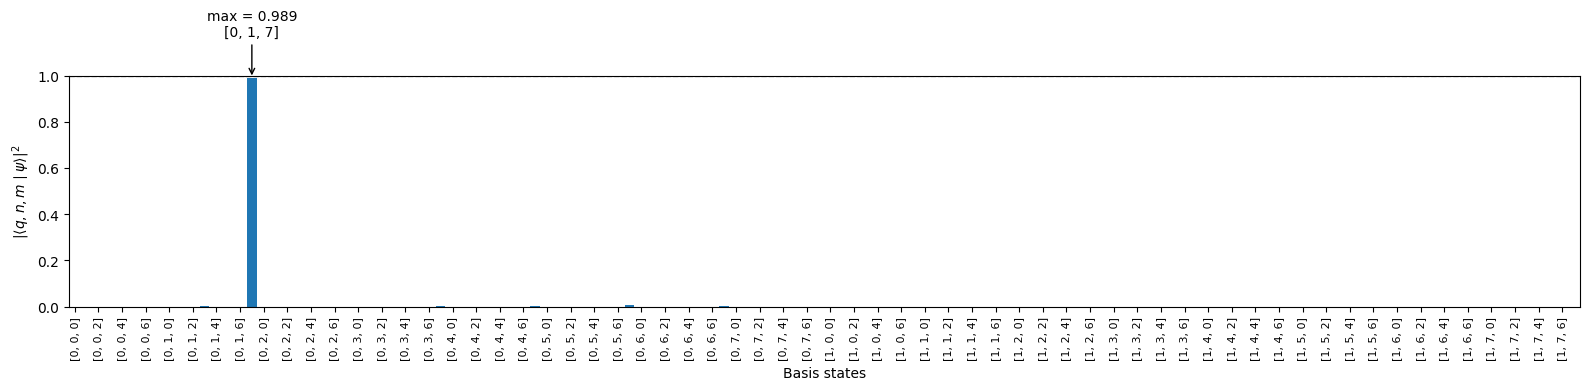

In [ ]:
# === Final basis-state probability histogram (single iteration) ===
import numpy as np
import matplotlib.pyplot as plt


triples = generate_triples(nfocks)                # shape: (2 * nfocks[0] * nfocks[1], 3)
P_final = num_prob_all(best_Xvec, ndepth, nfocks).ravel()  # ensure 1D


labels = [f"[{int(q)}, {int(n)}, {int(m)}]" for q, n, m in triples]


fig, ax = plt.subplots(figsize=(16, 4))
x = np.arange(len(P_final))
ax.bar(x, P_final)


max_ticks = 80
if len(labels) > max_ticks:
    step = int(np.ceil(len(labels) / max_ticks))
    ax.set_xticks(x[::step])
    ax.set_xticklabels(labels[::step], rotation=90, fontsize=8)
else:
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90, fontsize=8)


ax.set_xlim(-0.5, len(P_final) - 0.5)
ax.set_ylim(0.0, 1.0)
ax.axhline(1.0, linestyle="--", linewidth=1, color="0.6")
ax.set_xlabel("Basis states")
ax.set_ylabel(r"$|\langle q, n, m \mid \psi \rangle|^2$")


imax = int(np.argmax(P_final))
ax.annotate(f"max = {P_final[imax]:.3f}\n{labels[imax]}",
            xy=(imax, P_final[imax]),
            xytext=(0, 28), textcoords="offset points",
            ha="center", va="bottom",
            arrowprops=dict(arrowstyle="->", lw=1.0))

fig.tight_layout()
plt.show()
